In this notebook I will: 
- determine the appropriate parameter step sizes for stable numerical derivatives. We want to get away with the smallest step sizes for $\log M_{\rm min}$ and $\sigma_{\log M}$ due to the halo mass limit of the standard simulations 
- confirm that the numerical derivatives are consistent between the high and standard resolutions. 
- compare the derivatives taken at the fiducial HOD (w/ standard resolution sims) to the derivatives taken at the $M_r < -22$ best-fit HOD (w/ higher resolution sims). If they're similar, that's better since that means we're closer to an observed sample

In [1]:
import os 
import scipy as sp 
import numpy as np 
# --- eMaNu --- 
from emanu import util as UT
from emanu import forwardmodel as FM
from emanu.sims import data as simData

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline 

In [25]:
theta_lbls = [r'$\log M_{\rm min}$', r'$\sigma_{\log M}$',r'$\log M_0$',r'$\alpha$',r'$\log M_1$']
theta_names = ['logMin', 'sigma_logM', 'logM0', 'alpha', 'logM1']
#hod_fid = np.array([14.3, 0.45, 14.10, 0.87, 14.80]) # fiducial HOD parameters (selected from hod_fiducial.ipynb)
#hod_fid = np.array([14.30, 0.45, 14.00, 0.87, 14.69]) # fiducial HOD parameters (selected from hod_fiducial.ipynb)
hod_fid = np.array([13.65, 0.2, 14., 1.1, 14.])
hod_Mr22 = np.array([14.22, 0.77, 14.00, 0.87, 14.69]) # Zheng+(2007) Mr<-22

In [27]:
halos = simData.hqHalos('/Users/ChangHoon/data/emanu/halos/hades/0.0eV/1_hires', 4)
def Ncutoff(tt, seed=0): 
    '''number of galaxies populated in halos below the halo mass limit 
    '''
    hod = FM.hodGalaxies(halos, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed) 
    Ntot = len(np.array(hod['halo_mvir']))
    return np.sum(np.log10(np.array(hod['halo_mvir'])) < 13.118305), Ntot

def HMF_hod(tt, seed=0): 
    ''' halo mass function of halos with galaxies in them
    '''
    hod = FM.hodGalaxies(halos, {'logMmin': tt[0], 'sigma_logM': tt[1], 'logM0': tt[2], 'alpha': tt[3], 'logM1': tt[4]}, seed=seed) 
    _logMh = np.log10(np.array(hod['halo_mvir']))
    _hmf, _logMhbin = np.histogram(_logMh, bins=20, range=[12., 16])
    return 0.5*(_logMhbin[1:] + _logMhbin[:-1]), _hmf

In [5]:
# Zheng et al. halo occupation functions 
def Ncen_Mh(tt, logMh): 
    ''' expected Ncen at Mh 
    '''
    logMmin, sig_logM, _, _, _ = tt
    Ncen = 0.5 * (1. + sp.special.erf((logMh - logMmin)/sig_logM)) 
    Ncen[~np.isfinite(Ncen)] = 0. 
    return Ncen

def Nsat_Mh(tt, logMh): 
    ''' expected Nsat at Mh
    '''
    _Ncen = Ncen_Mh(tt, logMh) 
    _, _, logM0, alpha, logM1 = tt
    Nsat = _Ncen * ((10**logMh - 10**logM0)/10**logM1)**alpha
    Nsat[~np.isfinite(Nsat)] = 0. 
    return Nsat 

def Ngal_Mh(tt, logMh): 
    return Ncen_Mh(tt, logMh) + Nsat_Mh(tt, logMh)

In [6]:
rbins = np.array([0.1, 0.15848932, 0.25118864, 0.39810717, 0.63095734, 1., 1.58489319, 2.51188643, 3.98107171, 6.30957344, 10., 15.84893192, 25.11886432]) 

def wp_model(tt, res='LR', rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating wp 
    '''
    return np.loadtxt(f_wp(tt, res=res, rsd=rsd, seed=seed), unpack=True, usecols=[0,1])

def pk_model(tt, res='LR', rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating Pk 
    '''
    return np.loadtxt(f_pk(tt, res=res, rsd=rsd, seed=seed), unpack=True, usecols=[0,1])

def f_wp(tt, res='HR', rsd=True, seed=None):
    wp_dir = os.path.join('/Users/ChangHoon/data/emanu/hod', 'wp') 
    return os.path.join(wp_dir, 
            'wp.z07hod%.2f_%.2f_%.2f_%.2f_%.2f.%s.%i.%s.dat' % 
            (tt[0], tt[1], tt[2], tt[3], tt[4], ['rspace', 'zspace'][rsd], seed, res))

def f_pk(tt, res='HR', rsd=True, seed=None): 
    ''' return file name for wp given HOD parameters
    '''
    pk_dir = os.path.join('/Users/ChangHoon/data/emanu/hod', 'pk') 
    return os.path.join(pk_dir, 
            'pk.z07hod%.2f_%.2f_%.2f_%.2f_%.2f.%s.%i.%s.dat' % 
            (tt[0], tt[1], tt[2], tt[3], tt[4], ['rspace', 'zspace'][rsd], seed, res))

def dwpdtheta(tt, dtt, res='HR', rsd=True, log=True, nreal=1): 
    ''' calculate all dP(k)/dtheta derivatives numerically
    '''
    dwps = [] 
    for i in range(len(tt)): 
        _ttp = tt.copy() 
        _ttm = tt.copy() 
        _ttp[i] = tt[i] + dtt[i] 
        _ttm[i] = tt[i] - dtt[i] 
        wpp, wpm = [], [] 
        for ireal in range(nreal): 
            _, _wpp = wp_model(_ttp, res=res, rsd=rsd, seed=ireal)
            _r, _wpm = wp_model(_ttm, res=res, rsd=rsd, seed=ireal)
            wpp.append(_wpp)
            wpm.append(_wpm)
        wpp = np.average(np.array(wpp), axis=0)
        wpm = np.average(np.array(wpm), axis=0) 
        if log: dwp = 0.5*(np.log(wpp) - np.log(wpm))/dtt[i]
        else: dwp = 0.5*(wpp - wpm)/dtt[i]
        dwps.append(dwp) 
    return _r, dwps


def dpkdtheta(tt, dtt, res='HR', rsd=True, log=True, nreal=1): 
    ''' calculate all dP(k)/dtheta derivatives numerically
    '''
    dpks = [] 
    for i in range(len(tt)): 
        _ttp = tt.copy() 
        _ttm = tt.copy() 
        _ttp[i] = tt[i] + dtt[i] 
        _ttm[i] = tt[i] - dtt[i] 
        pkp, pkm = [], [] 
        for ireal in range(nreal): 
            k, _pkp = pk_model(_ttp, res=res, rsd=rsd, seed=ireal)
            k, _pkm = pk_model(_ttm, res=res, rsd=rsd, seed=ireal)
            pkp.append(_pkp)
            pkm.append(_pkm)
        pkp = np.average(np.array(pkp), axis=0)
        pkm = np.average(np.array(pkm), axis=0)
        if log: dpk = 0.5*(np.log(pkp) - np.log(pkm))/dtt[i] 
        else: dpk = 0.5*(pkp - pkm)/dtt[i]
        dpks.append(dpk) 
    return k, dpks

Lets begin by seeing how many galaxies would get cut off in $\theta^+$ and $\theta^-$ for some tentative fiducial step size

In [46]:
dthetas_fid = [0.05, 0.02, 0.2, 0.2, 0.2] # fiducial step sizes

(0.01, 50.0)

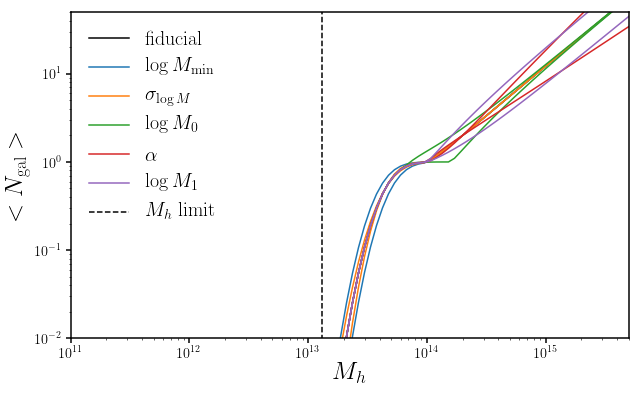

In [47]:
logMbin = np.linspace(11., 16., 100) # logMh bins

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.plot(10**logMbin, Ngal_Mh(hod_fid, logMbin), c='k', label='fiducial')
for i, dt in enumerate(dthetas_fid):
    _hod = hod_fid.copy()
    _hod[i] -= dt
    sub.plot(10**logMbin, Ngal_Mh(_hod, logMbin), c='C%i' % i, label=theta_lbls[i])
    _hod = hod_fid.copy()
    _hod[i] += dt
    sub.plot(10**logMbin, Ngal_Mh(_hod, logMbin), c='C%i' % i)
Mh_min = 13.118305
sub.plot([10**Mh_min, 10**Mh_min], [1e-3, 1e3], c='k', ls='--', label='$M_h$ limit')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel('$M_h$', fontsize=25)
sub.set_xscale('log')
sub.set_xlim(1e11, 5e15)
sub.set_ylabel(r'$<N_{\rm gal}>$', fontsize=25)
sub.set_yscale('log')
sub.set_ylim(1e-2, 5e1)

logMin-: 11 of 174097 galaxies are in halos below Mlim (0.000065)
logMin+: 0 of 144208 galaxies are in halos below Mlim (0.000004)
sigma_logM-: 0 of 156924 galaxies are in halos below Mlim (0.000003)
sigma_logM+: 12 of 159732 galaxies are in halos below Mlim (0.000078)
logM0-: 2 of 176746 galaxies are in halos below Mlim (0.000016)
logM0+: 2 of 142313 galaxies are in halos below Mlim (0.000020)
alpha-: 2 of 150463 galaxies are in halos below Mlim (0.000019)
alpha+: 2 of 170090 galaxies are in halos below Mlim (0.000017)
logM1-: 2 of 190146 galaxies are in halos below Mlim (0.000015)
logM1+: 2 of 138983 galaxies are in halos below Mlim (0.000021)


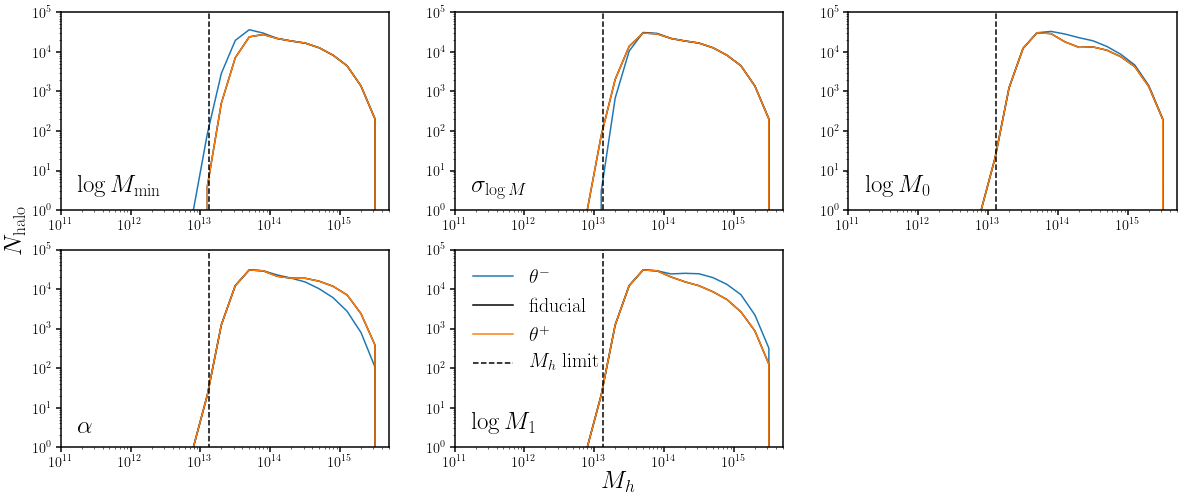

In [48]:
bin_hmf, hmf_fid = HMF_hod(hod_fid, seed=0) # fiducial Occupied Halo Mass Function 

fig = plt.figure(figsize=(20,8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    _thetam = hod_fid.copy()
    _thetam[i] -= dthetas_fid[i]
    
    _thetap = hod_fid.copy() 
    _thetap[i] += dthetas_fid[i]

    bin_hmf, hmf_m = HMF_hod(_thetam, seed=0)
    bin_hmf, hmf_p = HMF_hod(_thetap, seed=0)

    sub.plot(10**bin_hmf, hmf_m, label=r'$\theta^{-}$')
    sub.plot(10**bin_hmf, hmf_p, label=r'fiducial', c='k')
    sub.plot(10**bin_hmf, hmf_p, label=r'$\theta^{+}$')
    
    sub.plot([10**Mh_min, 10**Mh_min], [1e-3, 1e10], c='k', ls='--', label='$M_h$ limit')
    if i == 4: sub.legend(loc='upper left', fontsize=20)
    sub.set_xscale('log')
    sub.set_xlim(1e11, 5e15)
    sub.set_yscale('log')
    sub.set_ylim(1, 1e5)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
    
    ncut, ntot = [], [] 
    for ii in range(10): 
        _ncut, _ntot = Ncutoff(_thetam, seed=ii)
        ncut.append(_ncut)
        ntot.append(_ntot)
    print('%s-: %i of %i galaxies are in halos below Mlim (%f)' % 
          (theta_names[i], np.average(ncut), np.average(ntot), float(np.average(ncut))/float(np.average(ntot))))    
    ncut, ntot = [], [] 
    for ii in range(10): 
        _ncut, _ntot = Ncutoff(_thetap, seed=ii)
        ncut.append(_ncut)
        ntot.append(_ntot)
    print('%s+: %i of %i galaxies are in halos below Mlim (%f)' % 
          (theta_names[i], np.average(ncut), np.average(ntot), float(np.average(ncut))/float(np.average(ntot))))    
    
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$M_h$', fontsize=25) 
bkgd.set_ylabel(r'$N_{\rm halo}$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

All cosmologies with fiducial step sizes have very few galaxies below the halo mass limit. Great. 

Now lets confirm that the fiducial step sizes give sensible derivatives by comparing derivatives with different step sizes. 

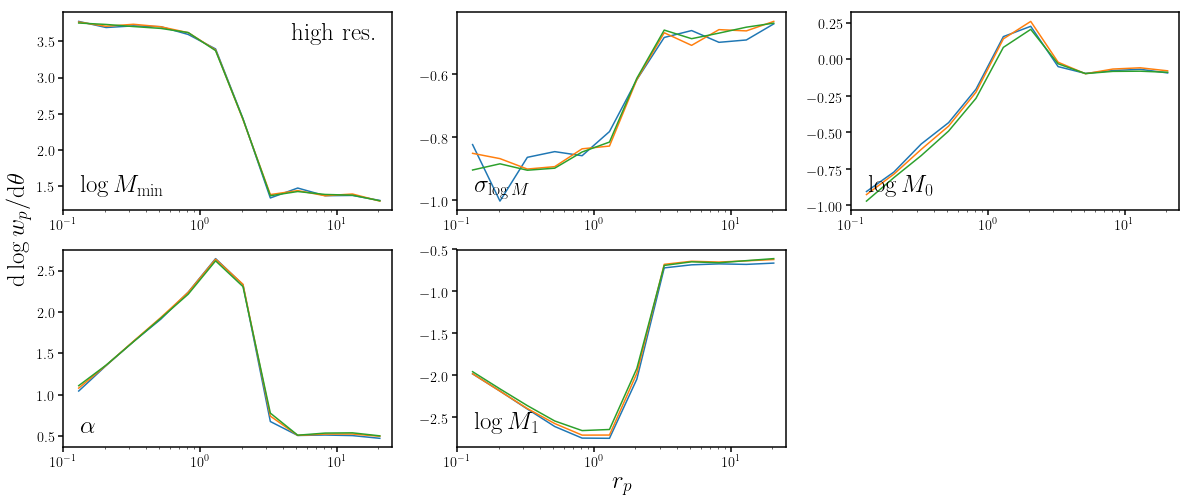

In [49]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    if i == 0: # Mmin 
        dtt = [0.05, 0.07, 0.1]
    elif i == 1: # sigma_logM
        dtt = [0.02, 0.05, 0.1] 
    elif i == 2: 
        dtt = [0.1, 0.2, 0.3] # 0.2
    elif i == 3: 
        dtt = [0.1, 0.2, 0.3] # 0.2
    elif i == 4:
        dtt = [0.1, 0.2, 0.3] # 0.2
    
    sub = fig.add_subplot(2,3,i+1)
    for _dtt in dtt: 
        _dtheta = np.zeros(5)
        _dtheta[i] = _dtt
        _, _dlogwps_hr = dwpdtheta(hod_fid, _dtheta, res='HR', rsd=True, log=True, nreal=10)

        sub.plot(0.5*(rbins[1:] + rbins[:-1]), _dlogwps_hr[i])
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

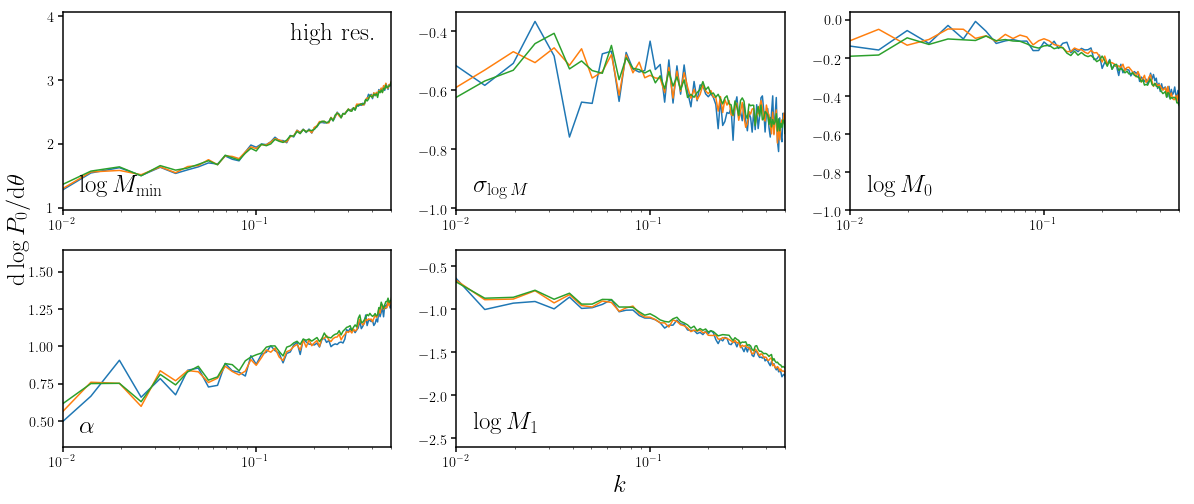

In [50]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    if i == 0: # Mmin 
        dtt = [0.05, 0.07, 0.1]
    elif i == 1: # sigma_logM
        dtt = [0.02, 0.05, 0.1] 
    elif i == 2: 
        dtt = [0.1, 0.2, 0.3] # 0.2
    elif i == 3: 
        dtt = [0.1, 0.2, 0.3] # 0.2
    elif i == 4:
        dtt = [0.1, 0.2, 0.3] # 0.2
    
    sub = fig.add_subplot(2,3,i+1)
    for _dtt in dtt: 
        _dtheta = np.zeros(5)
        _dtheta[i] = _dtt
        k, _dlogpks_hr = dpkdtheta(hod_fid, _dtheta, res='HR', rsd=True, log=True, nreal=5)
        sub.plot(k, _dlogpks_hr[i])
        
    sub.set_xscale('log') 
    sub.set_xlim(1e-2, 0.5) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log P_0/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

Based on the step size comparisons, it seems that for $M_{\rm min}$ and $\sigma_{\log M}$ we can get away with step sizes of 0.05. By eye, it seems that the following step sizes are sensible: 
$$\{\Delta M_{\rm min}, \Delta \sigma_{\log M}, \Delta \log M_0, \Delta \alpha, \Delta \log M_1\} = \{0.05, 0.05, 0.2, 0.2, 0.2\}$$


Next, lets see how similar the derivatives are to the derivatives at the $M_r < -22$ HOD best-fit

In [51]:
# get the derivative of wp and pk for the Mr=-22 sample for reference
_, dlogwps_Mr22 = dwpdtheta(hod_Mr22, np.array([0.1, 0.1, 0.2, 0.2, 0.15]), res='HR', rsd=True, log=True, nreal=10)
_, dlogpks_Mr22 = dpkdtheta(hod_Mr22, np.array([0.1, 0.1, 0.2, 0.2, 0.15]), res='HR', rsd=True, log=True, nreal=10)

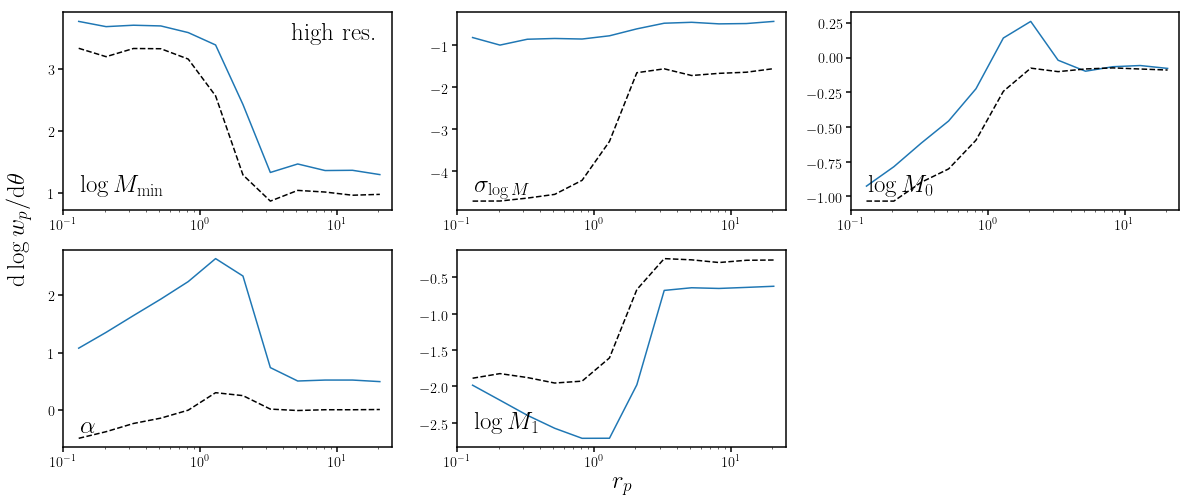

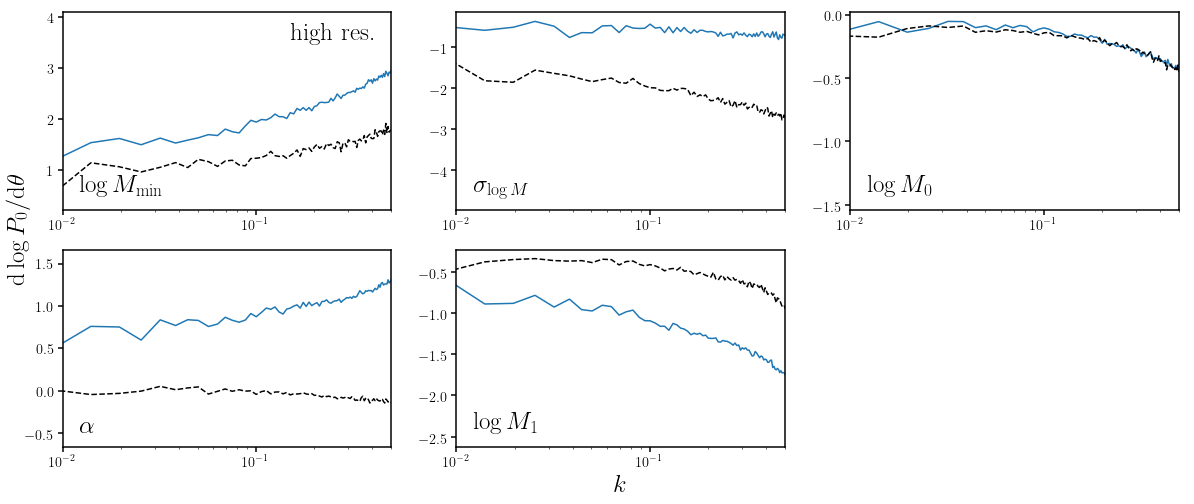

In [52]:
_, dlogwps_fid_hr = dwpdtheta(hod_fid, dthetas_fid, res='HR', rsd=True, log=True, nreal=10)
k, dlogpks_fid_hr = dpkdtheta(hod_fid, dthetas_fid, res='HR', rsd=True, log=True, nreal=5)

fig = plt.figure(figsize=(20, 8))
for i in range(5):    
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps_fid_hr[i])
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps_Mr22[i], c='k', ls='--')
    
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(k, dlogpks_fid_hr[i])
    sub.plot(k, dlogpks_Mr22[i], c='k', ls='--')
    sub.set_xscale('log') 
    sub.set_xlim(1e-2, 0.5) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log P_0/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

Unfortunately the derivatives are not very similar to the derivatives at the $M_r < -22$ HOD. However, it's a trade-off between number density and having a realistic sample. Now lets run some sanity checks that the galaxy clustering from the standard and high resolution HOD catalogs have consistent clustering modulo discrepancies in their halo clustering. 

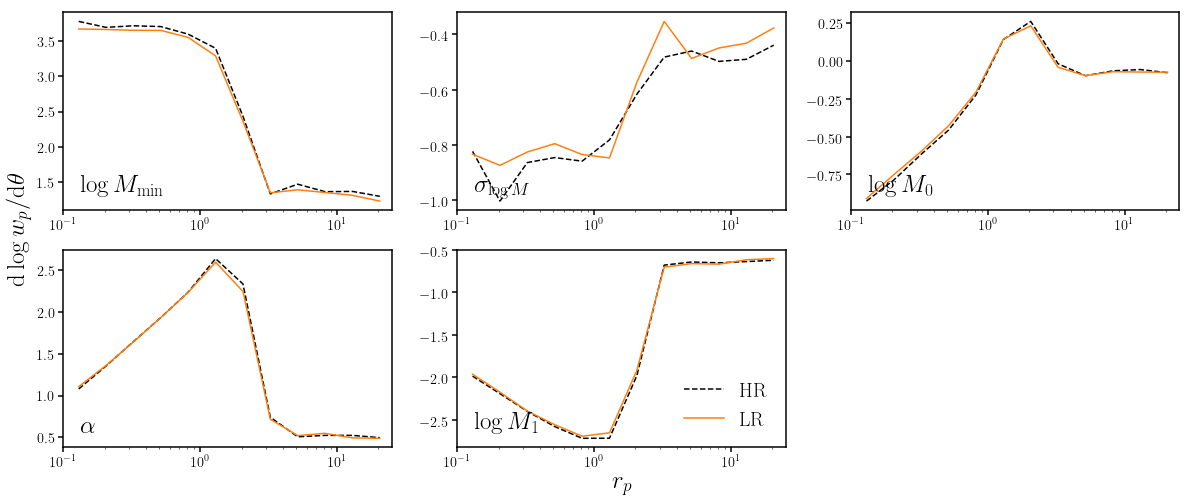

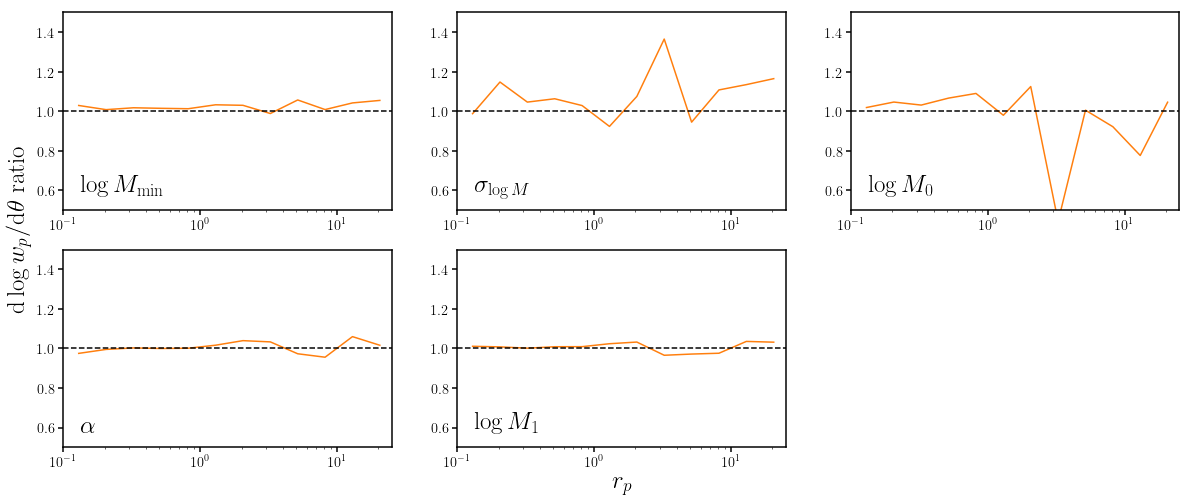

In [53]:
# step sizes that we decided on above
_, dlogwps_fid_lr = dwpdtheta(hod_fid, dthetas_fid, res='LR', rsd=True, log=True, nreal=10)
k, dlogpks_fid_lr = dpkdtheta(hod_fid, dthetas_fid, res='LR', rsd=True, log=True, nreal=5)

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps_fid_hr[i], c='k', ls='--', label='HR')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps_fid_lr[i], c='C1', label='LR')
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    #if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    if i == 4: sub.legend(loc='lower right', fontsize=20)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps_fid_hr[i]/dlogwps_fid_lr[i], c='C1')
    sub.plot([1e-1, 25], [1., 1.], c='k', ls='--')
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    sub.set_ylim(0.5, 1.5)
    if i == 4: sub.legend(loc='lower right', fontsize=20)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$ ratio', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

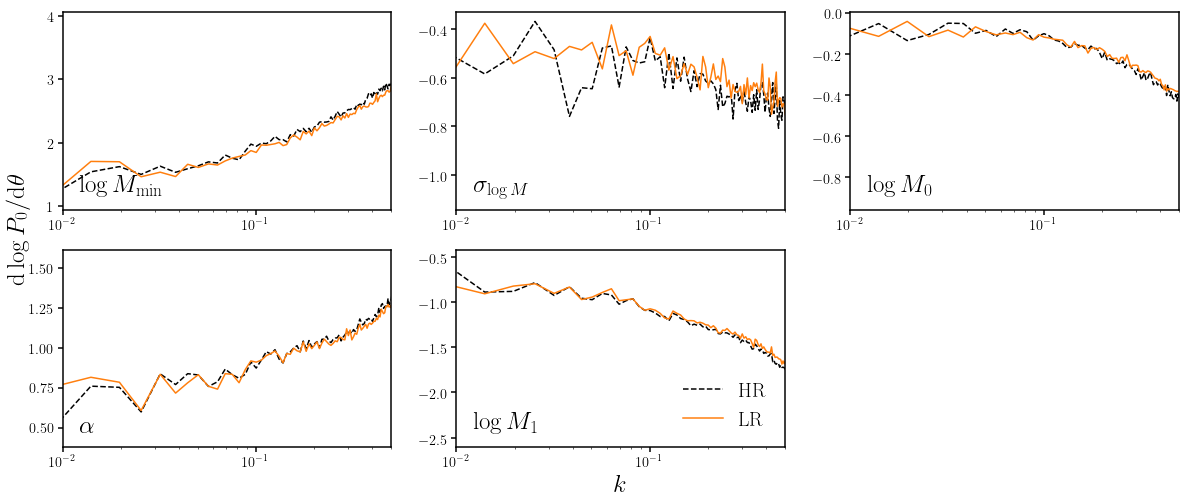

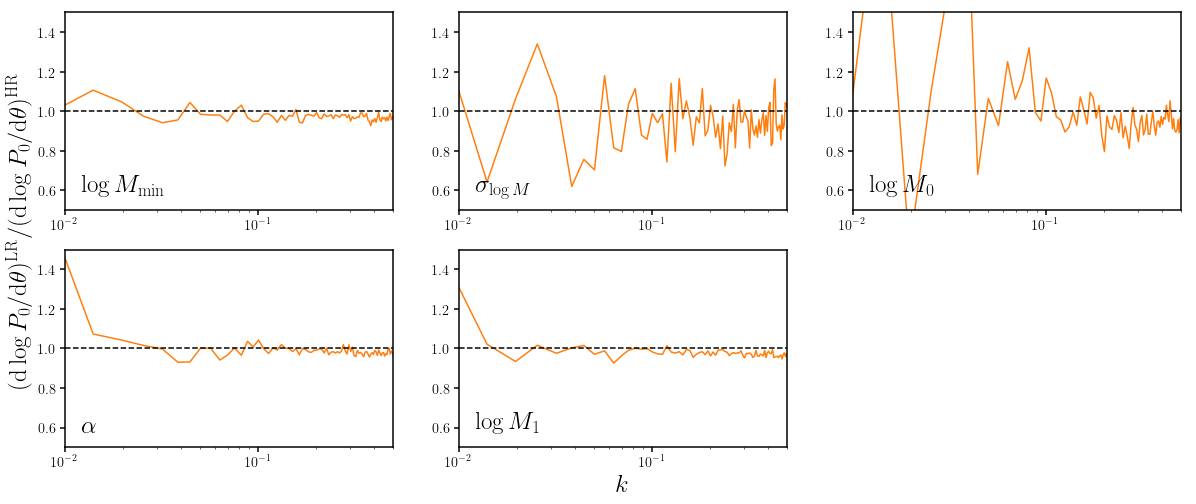

In [54]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(k, dlogpks_fid_hr[i], c='k', ls='--', label='HR')
    sub.plot(k, dlogpks_fid_lr[i], c='C1', label='LR')        
    sub.set_xscale('log') 
    sub.set_xlim(1e-2, 0.5) 
    #if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    if i == 4: sub.legend(loc='lower right', fontsize=20)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log P_0/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(k, dlogpks_fid_lr[i]/dlogpks_fid_hr[i], c='C1')
    sub.plot([1e-2, 0.5], [1., 1.], c='k', ls='--')
    sub.set_xscale('log') 
    sub.set_xlim(1e-2, 0.5) 
    sub.set_ylim(0.5, 1.5)
    if i == 4: sub.legend(loc='lower right', fontsize=20)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'$({\rm d} \log P_0/{\rm d} \theta)^{\rm LR}/({\rm d} \log P_0/{\rm d} \theta)^{\rm HR}$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)